# Referential Game with Realistic Images: Visualization

This notebook demonstrates a simplified version of the referential game using PyTorch and CIFAR-10 dataset, with intuitive visualizations.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Data Preparation

We'll use the CIFAR-10 dataset, which contains 60,000 32x32 color images in 10 classes.

Files already downloaded and verified


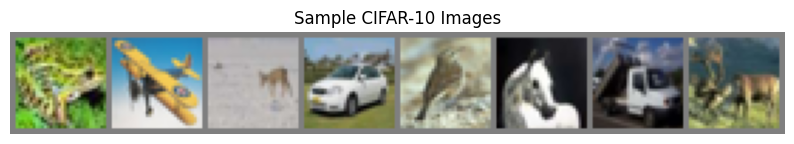

In [4]:
# Hyperparameters
batch_size = 64
image_size = 32
num_classes = 10
vocab_size = 10
message_length = 5

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Visualize some sample images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
plt.figure(figsize=(10, 4))
imshow(torchvision.utils.make_grid(images[:8]))
plt.title('Sample CIFAR-10 Images')
plt.show()

## Model Definition

We'll define simplified Sender and Receiver models.

In [5]:
class Sender(nn.Module):
    def __init__(self):
        super(Sender, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(32 * 8 * 8, message_length * vocab_size)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.view(-1, message_length, vocab_size)

class Receiver(nn.Module):
    def __init__(self):
        super(Receiver, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 32)
        self.lstm = nn.LSTM(32, 64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        return self.fc(h.squeeze(0))

sender = Sender().to(device)
receiver = Receiver().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=0.001)

## Training Visualization

Let's train our models and visualize the progress.

Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1, Loss: 2.3047, Accuracy: 9.92%


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2, Loss: 2.3037, Accuracy: 10.09%


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3, Loss: 2.3032, Accuracy: 10.22%


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4, Loss: 2.3033, Accuracy: 9.95%


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5, Loss: 2.3031, Accuracy: 10.08%


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6, Loss: 2.3030, Accuracy: 10.07%


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7, Loss: 2.3029, Accuracy: 9.97%


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8, Loss: 2.3029, Accuracy: 9.96%


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9, Loss: 2.3029, Accuracy: 9.94%


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10, Loss: 2.3029, Accuracy: 9.90%


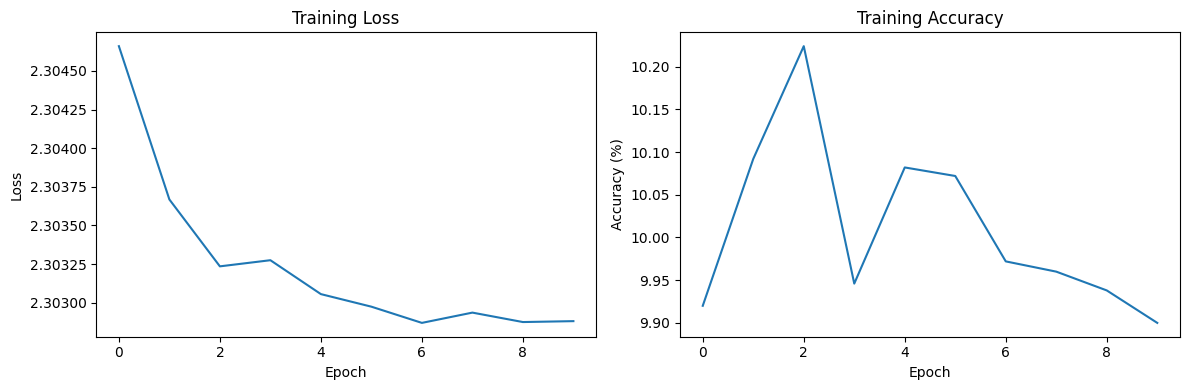

In [6]:
num_epochs = 10
losses = []
accuracies = []

for epoch in range(num_epochs):
    sender.train()
    receiver.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        
        # Sender generates message
        message_logits = sender(images)
        message = F.gumbel_softmax(message_logits, tau=1, hard=True)
        
        # Receiver tries to classify
        output = receiver(message.argmax(-1))
        
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss /= len(train_loader)
    epoch_acc = 100. * correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Plotting training progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

## Message Visualization

Let's visualize the messages generated by the Sender for different image classes.

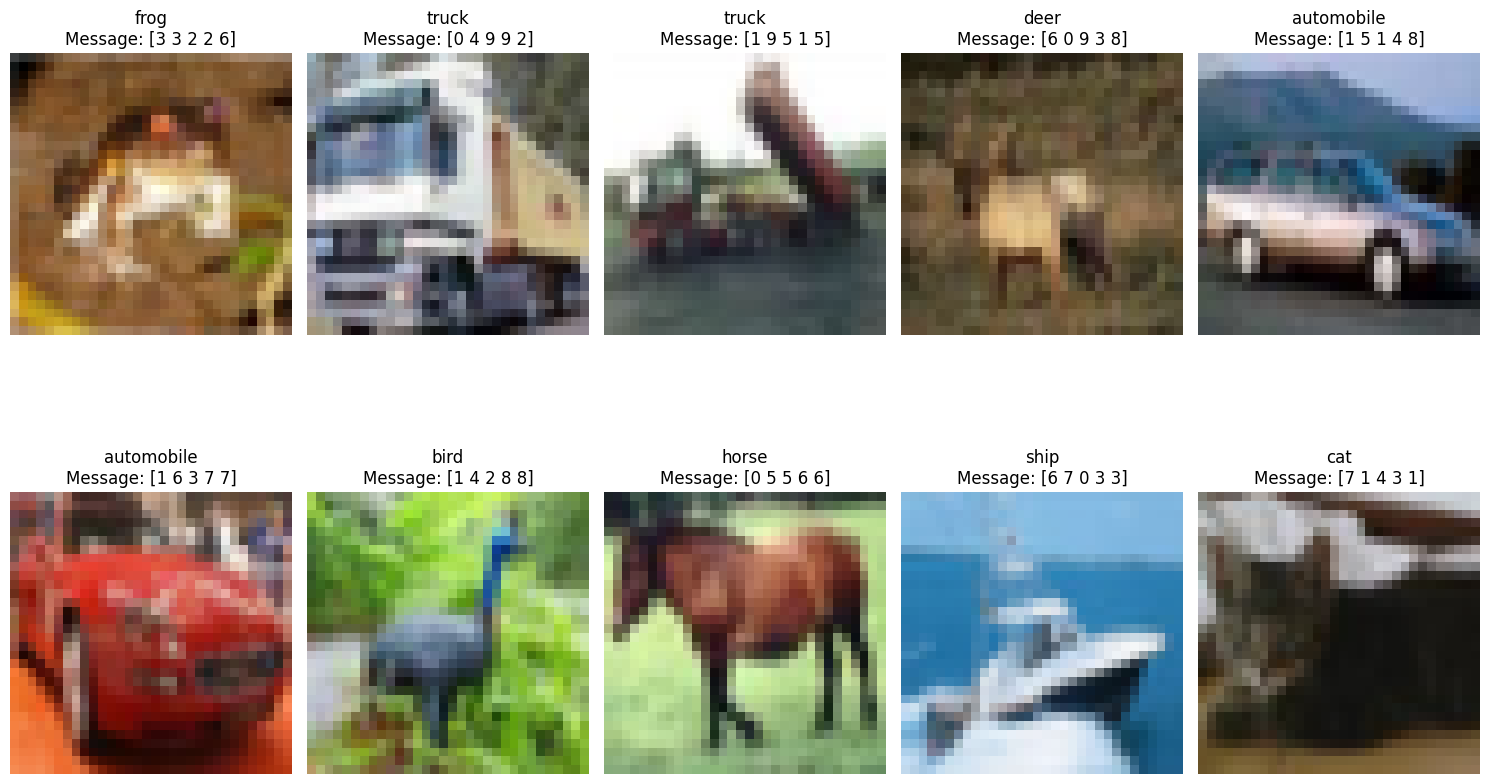

In [7]:
def get_message(image):
    with torch.no_grad():
        message_logits = sender(image.unsqueeze(0).to(device))
        message = F.gumbel_softmax(message_logits, tau=1, hard=True)
    return message.argmax(-1).cpu().numpy()[0]

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(15, 10))
for i, (image, label) in enumerate(train_dataset):
    if i >= 10:  # We'll visualize one image per class
        break
    
    plt.subplot(2, 5, i+1)
    imshow(image)
    message = get_message(image)
    plt.title(f'{class_names[label]}\nMessage: {message}')

plt.tight_layout()
plt.show()

## Message Clustering Visualization

Let's visualize how messages cluster for different image classes using t-SNE.

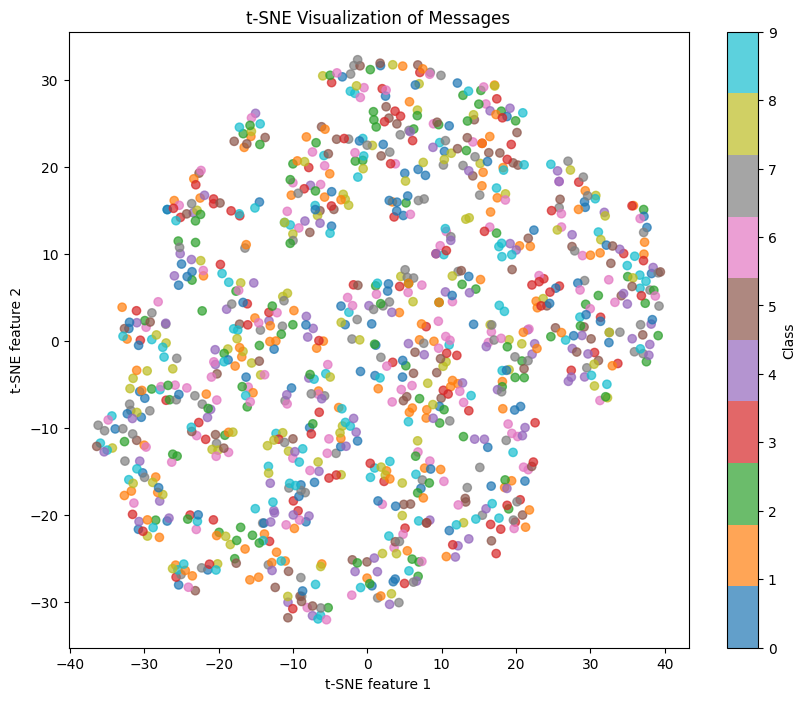

In [8]:
from sklearn.manifold import TSNE

# Generate messages for a subset of images
num_samples = 1000
messages = []
labels = []

for i, (image, label) in enumerate(train_dataset):
    if i >= num_samples:
        break
    message = get_message(image)
    messages.append(message)
    labels.append(label)

messages = np.array(messages)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
messages_2d = tsne.fit_transform(messages)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(messages_2d[:, 0], messages_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class')
plt.title('t-SNE Visualization of Messages')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

This visualization shows how the Sender has learned to create similar messages for images of the same class, forming clusters in the t-SNE plot.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64
image_size = 32
num_classes = 10
vocab_size = 20
message_length = 5
num_distractors = 3

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

class ReferentialGameDataset(Dataset):
    def __init__(self, dataset, num_distractors):
        self.dataset = dataset
        self.num_distractors = num_distractors

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        target_image, target_label = self.dataset[idx]
        distractor_indices = random.sample(range(len(self.dataset)), self.num_distractors)
        distractor_images = [self.dataset[i][0] for i in distractor_indices]
        
        all_images = [target_image] + distractor_images
        target_idx = 0  # The target is always the first image
        all_images = torch.stack(all_images)
        
        # Shuffle the images and update the target index
        perm = torch.randperm(len(all_images))
        all_images = all_images[perm]
        target_idx = perm.tolist().index(0)
        
        return all_images, target_idx, target_label

game_dataset = ReferentialGameDataset(train_dataset, num_distractors)
game_loader = DataLoader(game_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

class Sender(nn.Module):
    def __init__(self):
        super(Sender, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, message_length * vocab_size)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.view(-1, message_length, vocab_size)

class Receiver(nn.Module):
    def __init__(self):
        super(Receiver, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 64)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 8 * 8 + 256, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, message, images):
        batch_size, num_images, c, height, width = images.size()
        message = self.embedding(message)
        _, (lstm_out, _) = self.lstm(message)
        lstm_out = lstm_out.transpose(0, 1).contiguous().view(batch_size, -1)
        
        images = images.view(batch_size * num_images, c, height, width)
        image_features = self.conv(images)
        image_features = image_features.view(batch_size, num_images, -1)
        
        lstm_out_expanded = lstm_out.unsqueeze(1).expand(-1, num_images, -1)
        combined = torch.cat([lstm_out_expanded, image_features], dim=2)
        scores = self.fc(combined).squeeze(2)
        return scores

sender = Sender().to(device)
receiver = Receiver().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=0.001)

num_epochs = 20
losses = []
accuracies = []

for epoch in range(num_epochs):
    sender.train()
    receiver.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for images, target_indices, _ in tqdm(game_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, target_indices = images.to(device), target_indices.to(device)
        
        target_images = images[torch.arange(images.size(0)), target_indices]
        message_logits = sender(target_images)
        message = F.gumbel_softmax(message_logits, tau=1, hard=True)
        
        scores = receiver(message.argmax(-1), images)
        
        loss = criterion(scores, target_indices)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = scores.max(1)
        total += target_indices.size(0)
        correct += predicted.eq(target_indices).sum().item()
    
    epoch_loss /= len(game_loader)
    epoch_acc = 100. * correct / total
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)
    
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

Files already downloaded and verified


Epoch 1/20:   0%|          | 0/782 [00:00<?, ?it/s]

TypeError: view(): argument 'size' failed to unpack the object at pos 3 with error "type must be tuple of ints,but got Tensor"